In [1]:
import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as rng
import matplotlib.pyplot as plt

# training deps
import optax
from tqdm import tqdm

import stochastix as stx

jax.config.update('jax_enable_x64', True)
key = rng.PRNGKey(42)

plt.rcParams['font.size'] = 18

/Users/francesco/Documents/GitHub/stochastix/stochastix/utils/__init__.py:3: FutureWarning: The 'stochastix.utils.optimization' module is experimental and it may change or be removed without notice in future versions.
  from . import nn, optimization, visualization


# Positive Self-Loop Gene Expression

The model consists of four key reactions:

1. **Transcription**: DNA → mRNA (Hill activator kinetics, $k_{v0} + k_v \frac{K^n}{K^n + P^n}$)
2. **Translation**: mRNA → mRNA + Protein (rate constant $k_p$)  
3. **mRNA degradation**: mRNA → ∅ (rate constant $γ_m$)
4. **Protein degradation**: Protein → ∅ (rate constant $γ_p$)

This simple model captures the essential dynamics of positively self-regulating gene expression and is one of the classic network motifs. The model can be simulated using stochastic simulation algorithms (SSA) or solved deterministically as an ODE system. In the stochasic regime, the model can exibith a bimodal distribution of protein levels, a characteristic that is invisible in the deterministic ODE formulation. We'll demonstrate both parameter optimization using stochastic gradients and ODE-based training to fit the model to a target protein steady-state level.

In [2]:
# Define initial parameters

log_k_v = jnp.log(0.09)
log_k_n = jnp.log(3.5)
log_k_K = jnp.log(50.0)
log_k_v0 = jnp.log(1e-2)

log_k_p = jnp.log(0.025)
log_gamma_m = jnp.log(0.01)
log_gamma_p = jnp.log(0.002)

In [3]:
from stochastix import Reaction, ReactionNetwork
from stochastix.kinetics import HillActivator, MassAction

network = ReactionNetwork(
    [
        Reaction(
            '0 -> mRNA',
            HillActivator(
                regulator='P',
                v=log_k_v,
                K=log_k_K,
                n=log_k_n,
                v0=log_k_v0,
                transform_v=jnp.exp,
                transform_K=jnp.exp,
                transform_n=jnp.exp,
                transform_v0=jnp.exp,
            ),
            name='Transcription',
        ),
        Reaction(
            'mRNA -> mRNA + P',
            MassAction(log_k_p, transform=jnp.exp),
            name='Translation',
        ),
        Reaction(
            'mRNA -> 0',
            MassAction(log_gamma_m, transform=jnp.exp),
            name='mRNA_deg',
        ),
        Reaction(
            'P -> 0',
            MassAction(log_gamma_p, transform=jnp.exp),
            name='Protein_deg',
        ),
    ]
)

/Users/francesco/Documents/GitHub/stochastix/stochastix/kinetics/_hill.py:84: UserWarning: `v` is negative. Please ensure the provided `transform_v` maps it to a positive value.
  warnings.warn(
/Users/francesco/Documents/GitHub/stochastix/stochastix/kinetics/_hill.py:91: UserWarning: `v0` is negative. Please ensure the provided `transform_v0` maps it to a positive value.
  warnings.warn(


In [4]:
x0 = jnp.array([0.0, 0.0])

max_steps = int(1.5e4)
T = 3600.0 * 3

# couple reaction network to stochastic solver in a convenient way
model = stx.StochasticModel(
    network, stx.DifferentiableDirect(), T=T, max_steps=max_steps
)
mf_model = stx.MeanFieldModel(network, T=T)

In [5]:
print(network)

R0 (Transcription):  0 -> mRNA         |  HillActivator
R1 (Translation):    mRNA -> P + mRNA  |  MassAction
R2 (mRNA_deg):       mRNA -> 0         |  MassAction
R3 (Protein_deg):    P -> 0            |  MassAction


## Stochastic Simulations

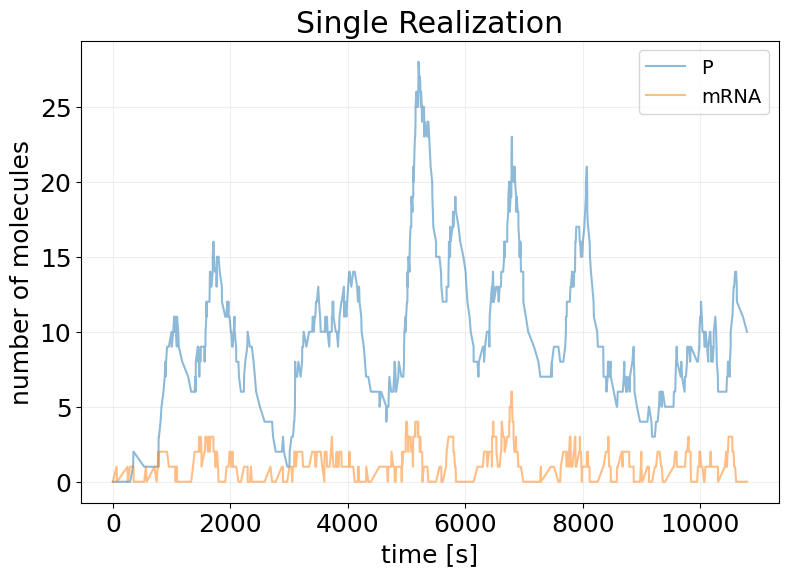

In [6]:
## Single Realization

key, subkey = rng.split(key)

sim_results = model(subkey, x0)

fig, ax = stx.plot_abundance_dynamic(sim_results)
ax.set_title('Single Realization')
ax.legend(fontsize=14);

In [7]:
## Ensemble Simulation

key, *subkeys = rng.split(key, 501)
subkeys = jnp.array(subkeys)

x0 = jnp.array([0.0, 0.0])

sim_init_ensemble_fn = eqx.filter_vmap(model, in_axes=(0, None))

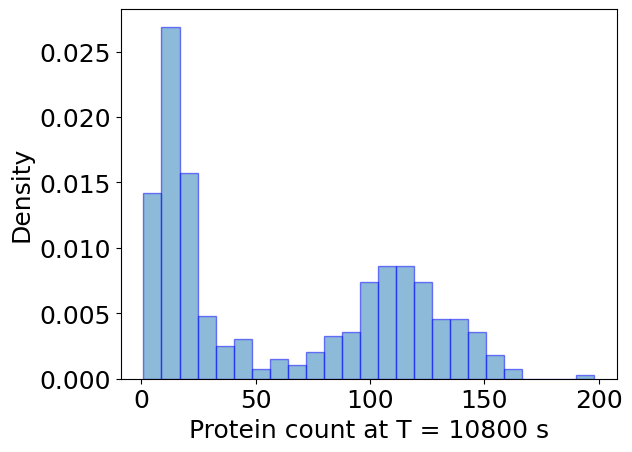

In [8]:
sim_init_ensemble = sim_init_ensemble_fn(subkeys, x0)

plt.hist(
    sim_init_ensemble.x[:, -1, 0],
    bins=25,
    alpha=0.5,
    label='Init.',
    density=True,
    edgecolor='b',
)

plt.xlabel(f'Protein count at T = {T:.0f} s')
plt.ylabel('Density')
plt.show()

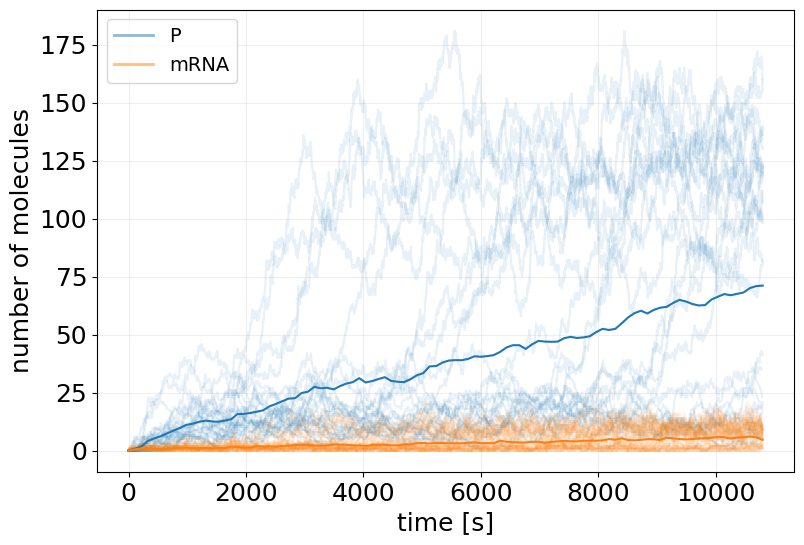

In [9]:
sim_init_ensemble = sim_init_ensemble_fn(subkeys[:30], x0)

fig, ax = stx.plot_abundance_dynamic(sim_init_ensemble, line_alpha=0.1)

t_interp = jnp.linspace(0, model.T, 100)
x_interp = sim_init_ensemble.interpolate(t_interp).x

ax.plot(t_interp, x_interp.mean(axis=0))
ax.legend(fontsize=14)
plt.show()

# Reparameterized Training

In [10]:
def loss_fn(model, x, y, key):
    sim_results = model(key, x)

    prot_idx = sim_results.species.index('P')

    return jnp.power(sim_results.x[-1, prot_idx] - y, 2)

In [11]:
def train_fstate(
    key,
    model,
    x0,
    y,
    LOSS_FN,
    EPOCHS=20,
    BATCH_SIZE=32,
    LEARNING_RATE=1e-3,
):
    # trick to vmap over named arguments
    loss_and_grads = eqx.filter_value_and_grad(LOSS_FN)
    loss_and_grads = eqx.filter_vmap(loss_and_grads, in_axes=(None, None, None, 0))

    losses = []

    opt = optax.adam(LEARNING_RATE)
    opt_state = opt.init(eqx.filter(model, eqx.is_array))

    @eqx.filter_jit
    def make_step(model, opt_state, key):
        key, *subkeys = rng.split(key, BATCH_SIZE + 1)
        subkeys = jnp.array(subkeys)

        loss, grads = loss_and_grads(model, x0, y, subkeys)

        grads = jax.tree.map(lambda x: x.mean(axis=0), grads)

        updates, opt_state = opt.update(grads, opt_state, model)

        model = eqx.apply_updates(model, updates)

        return model, opt_state, loss.mean()

    epoch_subkeys = rng.split(key, EPOCHS)

    pbar = tqdm(epoch_subkeys)
    for epoch_key in pbar:
        try:
            model, opt_state, loss = make_step(model, opt_state, epoch_key)

            losses += [float(loss)]

            pbar.set_description(f'Loss: {loss:.2f}')

        except KeyboardInterrupt:
            print('Training Interrupted')
            break

    log = {'loss': losses}

    return model, log

In [12]:
TARGET_PSS = 100.0

key, train_key = rng.split(key)

reparam_trained_model, log = train_fstate(
    train_key,
    model,
    x0,
    y=TARGET_PSS,
    LOSS_FN=loss_fn,
    EPOCHS=100,
    BATCH_SIZE=32,
    LEARNING_RATE=1e-2,
)

Loss: 315.84: 100%|██████████| 100/100 [00:44<00:00,  2.26it/s]


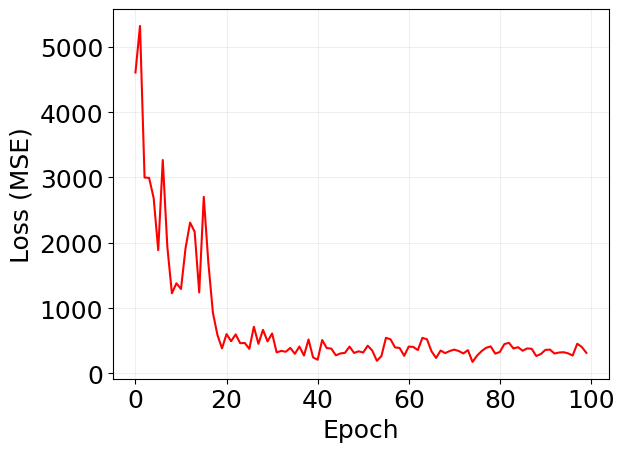

In [13]:
plt.plot(log['loss'], 'r')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')

plt.grid(alpha=0.2)

In [14]:
## Ensemble Simulation

key, *subkeys = rng.split(key, 31)
subkeys = jnp.array(subkeys)

x0 = jnp.array([0.0, 0.0])

sim_reparam_ensemble_fn = eqx.filter_vmap(reparam_trained_model, in_axes=(0, None))
sim_reparam_ensemble = sim_reparam_ensemble_fn(subkeys, x0)

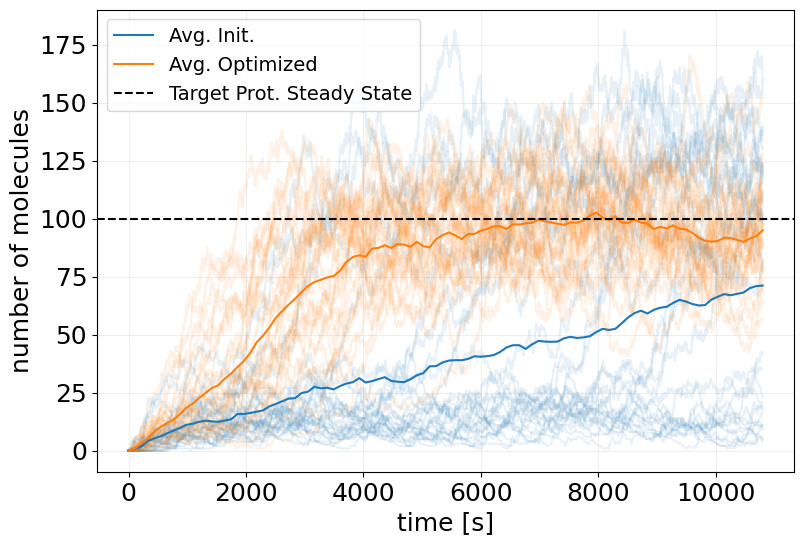

In [15]:
# plot initial ensemble
fig, ax = stx.plot_abundance_dynamic(
    sim_init_ensemble, 'P', line_alpha=0.1, legend=False
)

# plot trained ensemble
_, ax = stx.plot_abundance_dynamic(
    sim_reparam_ensemble, 'P', line_alpha=0.1, ax=ax, legend=False
)

# plot mean trajectories
t_interp = jnp.linspace(0, model.T, 100)
x_interp = sim_init_ensemble.interpolate(t_interp).x
x_interp_trained = sim_reparam_ensemble.interpolate(t_interp).x

ax.plot(t_interp, x_interp.mean(axis=0)[:, 0], label='Avg. Init.')
ax.plot(t_interp, x_interp_trained.mean(axis=0)[:, 0], label='Avg. Optimized')

ax.axhline(TARGET_PSS, color='k', linestyle='--', label='Target Prot. Steady State')

ax.legend(fontsize=14)
plt.show()

# REINFORCE Training

In [16]:
from stochastix.utils.optimization import (
    discounted_returns,
    neg_final_state_distance,
    reinforce_loss,
)

In [17]:
# training
def train_fstate_reinforce(
    key,
    model,
    x0,
    y,
    REWARDS_FN,
    LOSS_FN,
    EPOCHS=20,
    LEARNING_RATE=1e-3,
    BATCH_SIZE=32,
    REW_DISCOUNT=1.0,
    rew_avg_baseline=True,
):
    # trick to vmap over named arguments
    rewards_fn = lambda x, y: REWARDS_FN(x, target_ss=y)
    loss_and_grads = eqx.filter_vmap(
        eqx.filter_value_and_grad(LOSS_FN),
        in_axes=(None, eqx.if_array(0), 0),  # network, sim_results, rewards
    )

    losses = []
    rewards = []

    opt = optax.adam(LEARNING_RATE)
    opt_state = opt.init(eqx.filter(model, eqx.is_array))

    @eqx.filter_jit
    def make_step(model, opt_state, key):
        key, *subkeys = rng.split(key, BATCH_SIZE + 1)
        subkeys = jnp.array(subkeys)

        # TODO: check time overflow with checkify
        sim_results = eqx.filter_vmap(model, in_axes=(0, None))(subkeys, x0)

        rewards = eqx.filter_vmap(rewards_fn, in_axes=(eqx.if_array(0), None))(
            sim_results, y
        )

        returns = eqx.filter_vmap(discounted_returns, in_axes=(0, None))(
            rewards, REW_DISCOUNT
        )
        if rew_avg_baseline:
            returns = returns - returns.mean(axis=0)

        loss, grads = loss_and_grads(model, sim_results, returns)

        grads = jax.tree.map(lambda x: x.mean(axis=0), grads)

        updates, opt_state = opt.update(grads, opt_state, model)

        model = eqx.apply_updates(model, updates)

        rewards = jnp.mean(rewards.sum(axis=1))

        return model, opt_state, loss.mean(), rewards

    epoch_subkeys = rng.split(key, EPOCHS)

    pbar = tqdm(epoch_subkeys)
    for epoch_key in pbar:
        try:
            model, opt_state, loss, reward = make_step(model, opt_state, epoch_key)

            losses += [float(loss)]
            rewards += [float(reward)]

            pbar.set_description(f'Loss: {loss:.2f}, Reward: {reward:.2f}')

        except KeyboardInterrupt:
            print('Training Interrupted')
            break

        log = {'loss': losses, 'reward': rewards}

    return model, log

In [18]:
# train model

rewards_fn = neg_final_state_distance(species='P', distance='L2')

# create loss function
rloss_fn = reinforce_loss()

TARGET_PSS = 100.0

key, train_key = rng.split(key)

pg_trained_model, log_pg = train_fstate_reinforce(
    train_key,
    model,
    x0,
    TARGET_PSS,
    rewards_fn,
    rloss_fn,
    EPOCHS=100,
    LEARNING_RATE=1e-2,
    BATCH_SIZE=64,
    REW_DISCOUNT=1.0,
    rew_avg_baseline=True,
)

Loss: -360595.22, Reward: -391.58: 100%|██████████| 100/100 [01:18<00:00,  1.27it/s] 


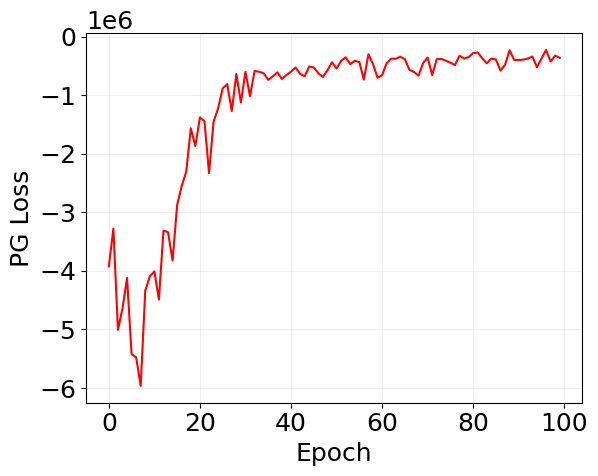

In [19]:
plt.plot(log_pg['loss'], 'r')
plt.xlabel('Epoch')
plt.ylabel('PG Loss')

plt.grid(alpha=0.2)

plt.show()

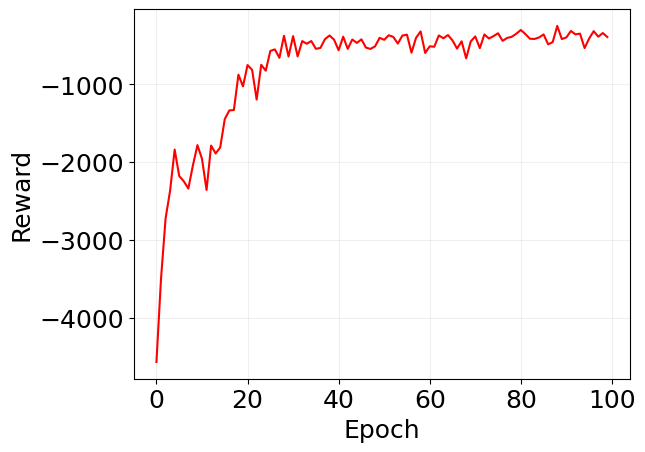

In [20]:
plt.plot(jnp.array(log_pg['reward']), 'r')
plt.xlabel('Epoch')
plt.ylabel('Reward')

plt.grid(alpha=0.2)

plt.show()

In [21]:
## Ensemble Simulation

key, *subkeys = rng.split(key, 31)
subkeys = jnp.array(subkeys)

x0 = jnp.array([0.0, 0.0])

sim_pg_ensemble_fn = eqx.filter_vmap(pg_trained_model, in_axes=(0, None))
sim_pg_ensemble = sim_pg_ensemble_fn(subkeys, x0)

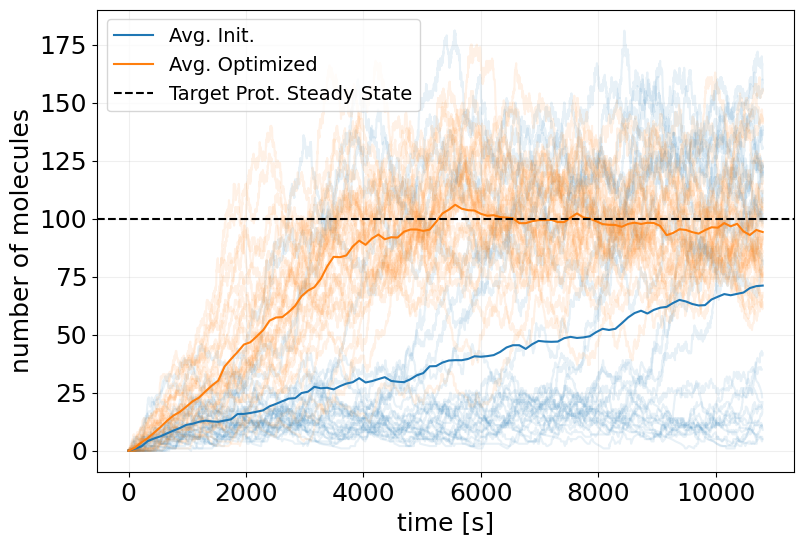

In [22]:
# plot initial ensemble
fig, ax = stx.plot_abundance_dynamic(
    sim_init_ensemble, 'P', line_alpha=0.1, legend=False
)

# plot trained ensemble
_, ax = stx.plot_abundance_dynamic(
    sim_pg_ensemble, 'P', line_alpha=0.1, ax=ax, legend=False
)

# plot mean trajectories
t_interp = jnp.linspace(0, model.T, 100)
x_interp = sim_init_ensemble.interpolate(t_interp).x
x_interp_trained = sim_pg_ensemble.interpolate(t_interp).x

ax.plot(t_interp, x_interp.mean(axis=0)[:, 0], label='Avg. Init.')
ax.plot(t_interp, x_interp_trained.mean(axis=0)[:, 0], label='Avg. Optimized')

ax.axhline(TARGET_PSS, color='k', linestyle='--', label='Target Prot. Steady State')

ax.legend(fontsize=14)
plt.show()

# Mean Field Training

In [23]:
TARGET_PSS = 100.0

key, train_key = rng.split(key)

mf_trained_model, log_mf = train_fstate(
    train_key,
    mf_model,
    x0,
    y=TARGET_PSS,
    LOSS_FN=loss_fn,
    EPOCHS=500,
    BATCH_SIZE=1,
    LEARNING_RATE=1e-4,
)

Loss: 0.00: 100%|██████████| 500/500 [00:04<00:00, 120.37it/s]   


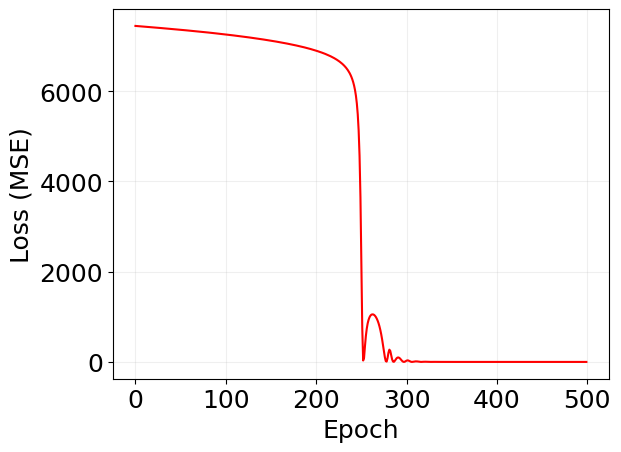

In [24]:
plt.plot(log_mf['loss'], 'r')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')

# plt.yscale('log')

plt.grid(alpha=0.2)

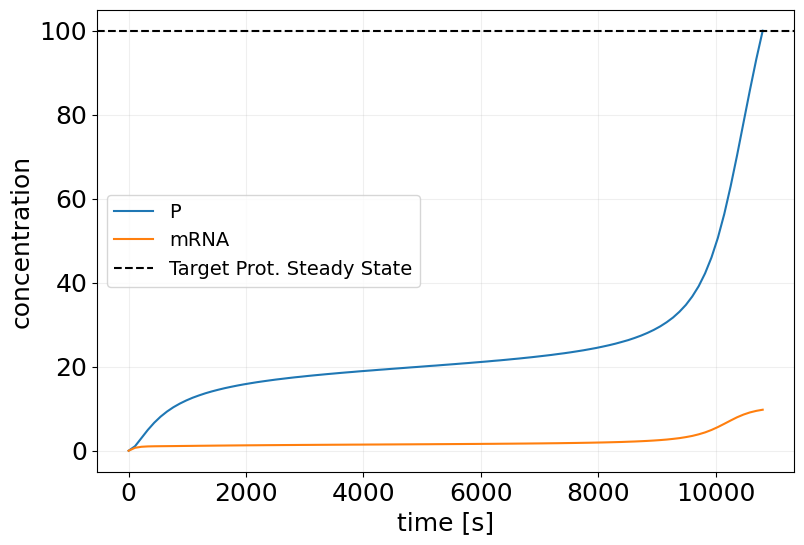

In [25]:
sim_mf_trained = mf_trained_model(key, x0, saveat_steps=100)

plt.figure(figsize=(9, 6))
plt.plot(sim_mf_trained.t, sim_mf_trained.x, label=sim_mf_trained.species)

plt.xlabel('time [s]')
plt.ylabel('concentration')

plt.axhline(TARGET_PSS, color='k', linestyle='--', label='Target Prot. Steady State')

plt.grid(alpha=0.2)

plt.legend(fontsize=14)

# Comparison

In [26]:
def sim_mf_ensemble_fn(ks, x0):
    sol = stx.stochsimsolve(ks, mf_trained_model.network, x0, T=mf_trained_model.T)
    return sol


sim_mf_ensemble_fn = eqx.filter_vmap(sim_mf_ensemble_fn, in_axes=(0, None))

In [27]:
# Sample from distributions
n_samples = 2048

key, *subkeys = rng.split(key, n_samples + 1)
subkeys = jnp.array(subkeys)

x0 = jnp.array([0.0, 0.0])

init_distr = sim_init_ensemble_fn(subkeys, x0).x[:, -1, 0]
print('Init. Mean:', init_distr.mean())
print('Init. Std:', init_distr.std())
print()

ode_distr = sim_mf_ensemble_fn(subkeys, x0).x[:, -1, 0]
print('ODE Mean:', ode_distr.mean())
print('ODE Std:', ode_distr.std())
print()

pg_distr = sim_pg_ensemble_fn(subkeys, x0).x[:, -1, 0]
print('PG Mean:', pg_distr.mean())
print('PG Std:', pg_distr.std())
print()

reparam_distr = sim_reparam_ensemble_fn(subkeys, x0).x[:, -1, 0]
print('Repar. Mean:', reparam_distr.mean())
print('Repar. Std:', reparam_distr.std())
print()

Init. Mean: 57.9267578125
Init. Std: 51.30313087078088

ODE Mean: 119.52392578125
ODE Std: 48.23295940401638

PG Mean: 99.07080078125
PG Std: 19.56478039183227

Repar. Mean: 99.88818359375
Repar. Std: 18.36638023325618



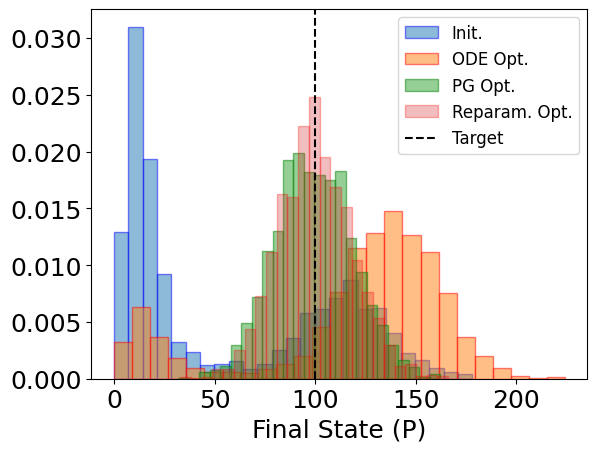

In [28]:
plt.hist(init_distr, bins=25, alpha=0.5, label='Init.', density=True, edgecolor='b')
plt.hist(ode_distr, bins=25, alpha=0.5, label='ODE Opt.', density=True, edgecolor='r')
plt.hist(pg_distr, bins=25, alpha=0.5, label='PG Opt.', density=True, edgecolor='g')
plt.hist(
    reparam_distr,
    bins=25,
    alpha=0.3,
    label='Reparam. Opt.',
    density=True,
    edgecolor='r',
)

plt.axvline(TARGET_PSS, color='k', linestyle='--', label='Target')

plt.xlabel('Final State (P)')

plt.legend(fontsize=12)

plt.show()

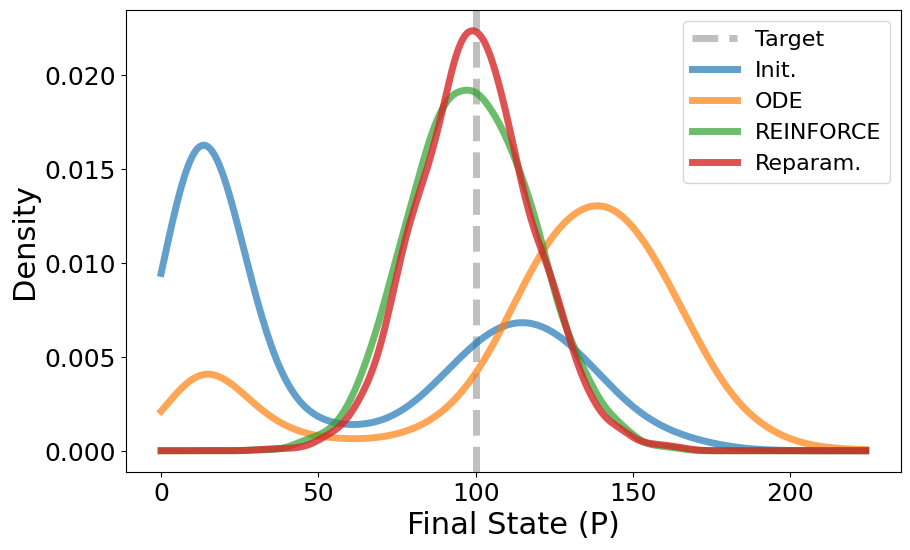

In [29]:
import numpy as np
from scipy.stats import gaussian_kde

plt.figure(figsize=(10, 6))

plt.axvline(
    TARGET_PSS, color='gray', linestyle='--', linewidth=5, label='Target', alpha=0.5
)


# Create x range for smooth curves
x_min = min(init_distr.min(), ode_distr.min(), pg_distr.min(), reparam_distr.min())
x_max = max(init_distr.max(), ode_distr.max(), pg_distr.max(), reparam_distr.max())
x_range = np.linspace(x_min, x_max, 300)

# Create KDE for each distribution and plot
kde_init = gaussian_kde(init_distr)
plt.plot(x_range, kde_init(x_range), alpha=0.7, label='Init.', linewidth=5)

kde_ode = gaussian_kde(ode_distr)
plt.plot(x_range, kde_ode(x_range), alpha=0.7, label='ODE', linewidth=5)

kde_pg = gaussian_kde(pg_distr)
plt.plot(x_range, kde_pg(x_range), alpha=0.7, label='REINFORCE', linewidth=5)

kde_reparam = gaussian_kde(reparam_distr)
plt.plot(x_range, kde_reparam(x_range), alpha=0.8, label='Reparam.', linewidth=5)


plt.xlabel('Final State (P)', fontsize=22)
plt.ylabel('Density', fontsize=22)

plt.legend(fontsize=16)

plt.show()